## Import modules

In [157]:
import numpy as np
import itertools

# to get and read data
import os
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [158]:
# import python file containing functions
!pip install import_ipynb
import import_ipynb
import myfunctions

In [159]:
# to relead notebook after editing
import importlib
importlib.reload(myfunctions)

importing Jupyter notebook from myfunctions.ipynb


<module 'myfunctions' from 'myfunctions.ipynb'>

## get and read data

get data

In [160]:
# download zip
myfunctions.download_file(url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip',
                      saveAs = 'CharacterTrajectories.zip')

# extract folder from zip
if not os.path.exists('CharacterTrajectories'):
    with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall('CharacterTrajectories')
    print('folder extracted from zip')
else:
    print('zip already extracted')

file downloaded
zip already extracted


read data

In [161]:
# ignoring metadata at index 1, arff -> (data,meta)
train_data, train_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')
test_data, test_meta = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')

### preprocess

In [162]:
# function to remove nan values
def remove_nan(data):
  inputs = []
  labels = [] 
    
  for sample in data:
    input = sample[0]
    # subtract 1 from labels to start indexing from 0
    labels.append(int(sample[1])-1)

    # get length excluding nan values which indicate end of input
    lens = []
    for channel in input:
      channel = list(channel)
      len1 = np.where(np.isnan(list(channel)))[0][0] if any(np.isnan(channel)) else len(channel)
      lens.append(len1)
    inputLen = np.min(lens)

    channels = []
    for channel in input:
      channels.append(list(channel)[:inputLen])
    inputs.append(channels)  
        
  data1 = list(zip(inputs,labels))
  return data1

In [163]:
train_data = remove_nan(train_data)
test_data = remove_nan(train_data)

max length = 180


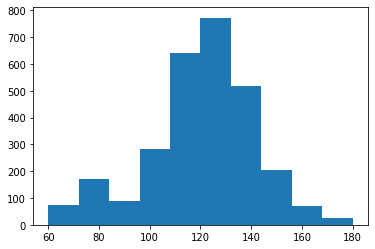

In [164]:
# distribution of sample lenghts
lengths = []

for sample in itertools.chain(train_data,test_data):
  input = sample[0][0]
  input = np.array(input)
  lengths.append(len(input))

print('max length =',np.max(lengths))
_ = plt.hist(lengths)

In [165]:
classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')

number of classes : 20

train data contains 1422 samples
test data contains 1422 samples

each sample has 3 channels : x,y and force


## patches

In [243]:
kwargs = {'window_size':20, 'stride':10, 'resizeTo':100, 'medianFilter':True, 'gaussianFilter':True, 'normalize':True}

kwargs['data'] = train_data
train_inputs, train_labels, train_indexes = myfunctions.dataToPatches(**kwargs)
kwargs['data'] = test_data
test_inputs, test_labels, test_indexes = myfunctions.dataToPatches(**kwargs)

create dataset and dataloader

In [210]:
train_loader, val_loader, test_loader = myfunctions.createLoaders(train_inputs, train_labels,
                                                                  test_inputs, test_labels,
                                                                  batch_size=32)

### visualize patches

In [231]:
def toPlot_char(char):
    
    xVel  = char[0]
    yVel  = char[1]
    force = char[2]
    
    xPos  = np.cumsum(xVel)
    yPos  = np.cumsum(yVel) 
    
    #normalize force between 0 and 1
    color = (force - np.min(force)) / (np.max(force)-np.min(force))
    #define color based on force
    colormap = matplotlib.cm.inferno
  
    X = []; Y = []; C=[]
    for i,c in enumerate(color[:-1]):
      #_ = plt.plot([xPos[i],xPos[i+1]], [yPos[i],yPos[i+1]], color=colormap(c),
      #             marker='o', markersize=3.5, markerfacecolor='black')
      X.append([xPos[i],xPos[i+1]])
      Y.append([yPos[i],yPos[i+1]])
      C.append(colormap(c))
    
    return X,Y,C

a


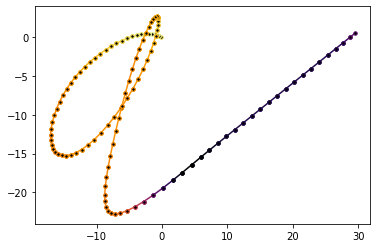

10 patches


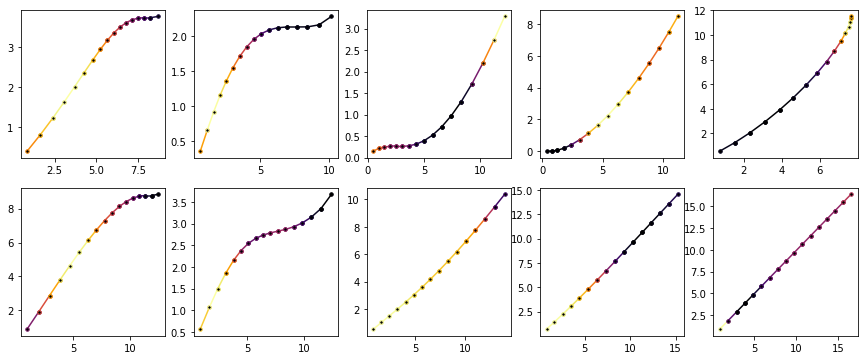

In [248]:
#np.random.seed(0)

# random sample of randomly selected character
rnd_index = np.random.choice((len(train_data)))

# random sample of manually selected character
index = classes.index('a')
indexes = np.where(np.array(train_data)==index)[0]
rnd_index = np.random.choice(indexes)

input, label = train_data[rnd_index]

print(classes[int(label)])
X,Y,C = toPlot_char(input)
for x,y,c in zip(X,Y,C):
  plt.plot(x, y, color=c, marker='o', markersize=3.5, markerfacecolor='black')
plt.show()

indexes = np.where(train_indexes == rnd_index)[0]
n_patches = len(indexes)
print(n_patches,'patches')
cols = int(np.ceil(n_patches/2))
fig, axs = plt.subplots(2,cols, figsize=(15,6))

for i,index in enumerate(indexes):
  input = train_inputs[index]
  indicator = input[3]
  indicator = np.where(indicator==1)[0]
  input = [np.take(channel,indicator) for channel in input[:3]]

  X,Y,C = toPlot_char(input)
  for x,y,c in zip(X,Y,C):
    axs[0 if i<cols else 1,i%cols].plot(x, y, color=c, marker='o', markersize=3.5, markerfacecolor='black')

## neural network

### define network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 4 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(4, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(368, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### create network

In [ ]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 25, train loss: 1.761, val loss: 1.798
epoch: 50, train loss: 0.846, val loss: 1.005
epoch: 75, train loss: 0.657, val loss: 0.841
epoch: 100, train loss: 0.547, val loss: 0.809
epoch: 125, train loss: 0.474, val loss: 0.826
epoch: 150, train loss: 0.419, val loss: 0.828

Finished Training


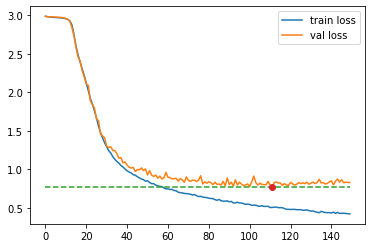

In [ ]:
best_params = myfunctions.trainNet(net,criterion,optimizer, 
                                  train_loader,val_loader,
                                  epochs=150)

In [ ]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [ ]:
print("evaluation results on train data")
myfunctions.evaluate(net,train_loader,classes)
print("evaluation results on test data")
myfunctions.evaluate(net,test_loader,classes)

evaluation results on train data



              precision    recall  f1-score   support

           a     0.8275    0.8395    0.8334       760
           b     0.6650    0.8571    0.7489       623
           c     0.9661    0.9814    0.9737       377
           d     0.8887    0.7972    0.8405       641
           e     0.9430    0.9650    0.9539       686
           g     0.7627    0.7912    0.7767       589
           h     0.8119    0.4930    0.6135       499
           l     0.9945    0.9890    0.9918       365
           m     0.8754    0.8969    0.8860       611
           n     0.6592    0.6857    0.6722       474
           o     0.9474    0.8588    0.9009       524
           p     0.8792    0.6287    0.7331       579
           q     0.8645    0.9634    0.9113       629
           r     0.7161    0.7071    0.7116       478
           s     0.8634    0.9394    0.8998       545
           u     0.6022    0.7381    0.6633       527
           v     0.9731    0.9883    0.9807       513
           w     0.7775   


              precision    recall  f1-score   support

           a     0.7565    0.7240    0.7399      1000
           b     0.5839    0.7815    0.6684       842
           c     0.9187    0.9492    0.9337       512
           d     0.8028    0.8028    0.8028       857
           e     0.8962    0.9111    0.9036       900
           g     0.6075    0.6410    0.6238       780
           h     0.6977    0.3765    0.4891       656
           l     0.9710    0.9552    0.9630       491
           m     0.8093    0.7943    0.8017       812
           n     0.5268    0.5507    0.5385       661
           o     0.8792    0.8285    0.8531       694
           p     0.7561    0.5273    0.6213       770
           q     0.7721    0.9221    0.8404       834
           r     0.6237    0.5395    0.5786       645
           s     0.8391    0.9037    0.8702       727
           u     0.5185    0.6490    0.5764       735
           v     0.9003    0.9592    0.9288       687
           w     0.6269   